In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np


In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [5]:
# reshape the data
X_train = X_train.reshape((X_train.shape[0], 28, 28))
X_test = X_test.reshape((X_test.shape[0], 28, 28))
# change the type to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# convert data to 3 channels
X_train = np.stack((X_train,)*3, axis=-1)
X_test = np.stack((X_test,)*3, axis=-1)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [62]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28, 3), (10000, 28, 28, 3), (60000, 10), (10000, 10))

Maybe take out rotation range to help with accuracy
What if I do not use .flow for generator rather i use apply_transform, then into my model i pass that plus the y values rather than jus the train_iterator
why does model.predict return 32,10 when i only pass 1 value

In [7]:

# data augmentation with generator
train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow(X_train, y_train, batch_size=512, shuffle=True)

val_iterator = val_generator.flow(X_test, y_test, batch_size=512, shuffle=False)

In [84]:
bum = tf.keras.losses.CategoricalCrossentropy()
bum(X_train[1], y_train[1])


ValueError: Shapes (28, 28, 3) and (10,) are incompatible

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [9]:
model = Sequential()
# add the pretrained model
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
# add fully connected layer with output
model.add(Dense(10, activation='softmax'))

# set resnet layers not trainable
model.layers[0].trainable=False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23608202 (90.06 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [10]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(train_iterator, epochs=10)

Epoch 1/10
118/118 [==============================] - 61s 481ms/step - loss: 2.0214 - accuracy: 0.3707
Epoch 2/10
118/118 [==============================] - 82s 695ms/step - loss: 1.5963 - accuracy: 0.5473
Epoch 3/10
118/118 [==============================] - 84s 709ms/step - loss: 1.3977 - accuracy: 0.6064
Epoch 4/10
118/118 [==============================] - 85s 720ms/step - loss: 1.2740 - accuracy: 0.6382
Epoch 5/10
118/118 [==============================] - 89s 753ms/step - loss: 1.1822 - accuracy: 0.6667
Epoch 6/10
118/118 [==============================] - 84s 706ms/step - loss: 1.1143 - accuracy: 0.6835
Epoch 7/10
118/118 [==============================] - 89s 750ms/step - loss: 1.0571 - accuracy: 0.6999
Epoch 8/10
118/118 [==============================] - 120s 1s/step - loss: 1.0105 - accuracy: 0.7117
Epoch 9/10
118/118 [==============================] - 100s 847ms/step - loss: 0.9787 - accuracy: 0.7195
Epoch 10/10
118/118 [==============================] - 65s 551ms/step - lo

In [89]:

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label, model):
  with tf.GradientTape() as tape: 
    tape.watch(input_image)
    prediction = model(input_image)[0]
    loss = loss_object(input_label, prediction)

    #Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    #Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad


In [17]:
decode_predictions = tf.keras.applications.resnet50.decode_predictions
def get_label(probs):
  return decode_predictions(probs, top=1)[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 28, 3)


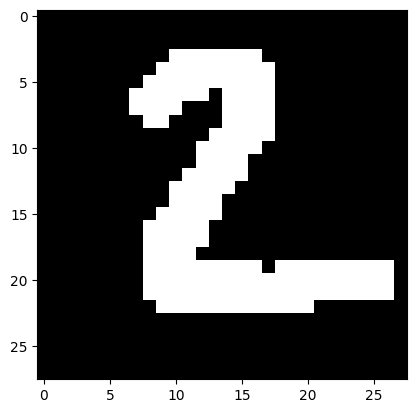

1/1 [==============================] - 0s 104ms/step


ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (32, 10)

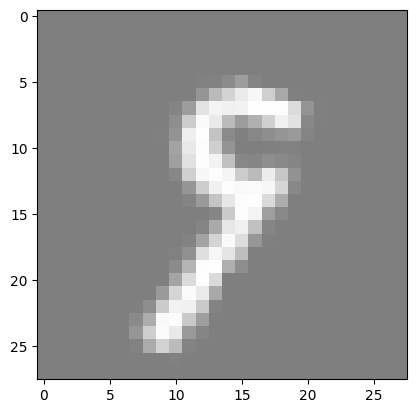

In [79]:
from matplotlib import pyplot as plt
from matplotlib.cbook import flatten
# pick a sample to plot
sample = 1
image = X_test[sample]
# plot the sample

fig = plt.figure
plt.imshow(image, cmap='gray_r')
plt.show()
image = train_generator.flow(X_test)[1]
image_probs = model.predict(image)

plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
image_class, class_confidence = get_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(str(image_class), float((class_confidence*100).flatten)))
plt.show()

In [96]:
def display_images(image):
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)

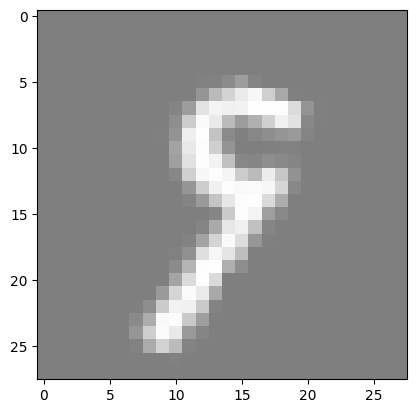

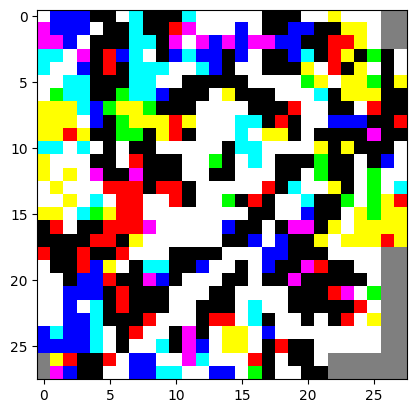

In [100]:
display_images(image)
image = tf.Variable(image)
label = y_test[sample]

perturbations = create_adversarial_pattern(image, label, model)

display_images(perturbations)  # To change [-1, 1] to [0,1]

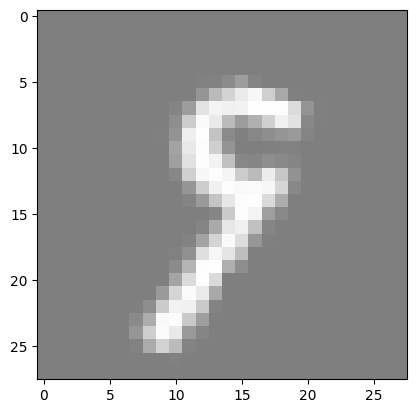

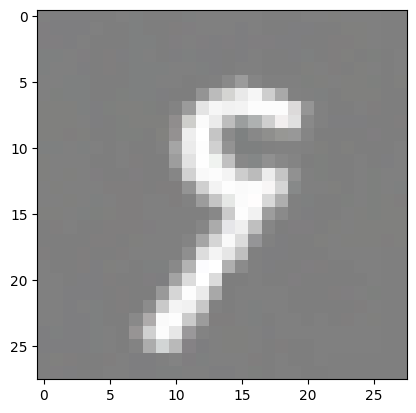

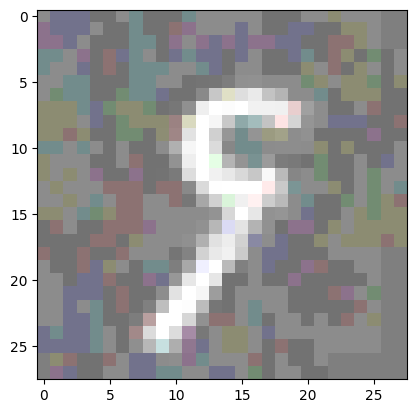

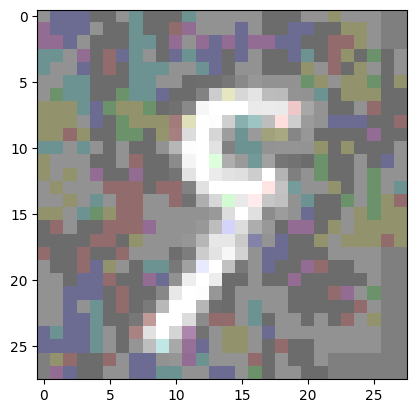

In [99]:
epsilons = [0, 0.01, 0.1, 0.15]
for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x)